#### **1. Import all neccessery libraries.**

In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import json
import calendar

#### **2. Get data.**

    From GoogleCloud and create a Data Frame 'df'.
    This Data Set consists of first new wallets's outgoing transactions in 2023.
    There is a sample which was chosen like 20000 fist raws from 1% sample of table `all_new_wallets_2023`

NOTE:

    'first_transactions_sample_with_input' was previously created with SQL-queries on BigQuery.
    All queries are saved in query_ethereum_project.txt

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'my-project-444222-1be5aecf7dbb.json'

In [3]:
client = bigquery.Client()

query = """
SELECT *
FROM `my-project-444222.wallets_2023.first_transactions_sample_with_input`
"""
df = client.query(query).to_dataframe()

#### **3. Check DataFrame.**

In [4]:
df.head(5)

,from_address,first_transaction_time,to_address,value,input,gas,gas_price,transaction_type,receipt_gas_used
0,0x6475e88ef19683a1345866398f45ab2549dbd621,2023-01-20 23:53:23+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb000000000000000000000000bb3fd383d1c5...,63429,25123969051,0,43725
1,0x49a64a902c99bf44e159d17a8b334d0c054dc612,2023-11-04 02:29:35+00:00,0xdef1c0ded9bec7f1a1670819833240f027b25eff,2718019107674500.000000000,0x3598d8ab000000000000000000000000000000000000...,171677,13626377233,2,140381
2,0xa6481f04f959be573f85bafa962dd5716c75036f,2023-02-13 07:51:59+00:00,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,0E-9,0xa9059cbb000000000000000000000000c610ff51929c...,316657,14899917470,2,226075
3,0x8f0ab55f38f530345d271600eb3c0d08c1df19df,2023-06-12 12:18:11+00:00,0x8e16bf47065fe843a82f4399baf5abac4e0822b7,0E-9,0xa9059cbb000000000000000000000000c30badb28e20...,62243,15750000000,0,56963
4,0x92508951402cf163ace0e23424b1d888e13c093b,2023-09-14 13:06:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb0000000000000000000000001689a089aa12...,170000,33000000000,0,43701


In [5]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   from_address            20000 non-null  object             
 1   first_transaction_time  20000 non-null  datetime64[us, UTC]
 2   to_address              19867 non-null  object             
 3   value                   20000 non-null  object             
 4   input                   20000 non-null  object             
 5   gas                     20000 non-null  Int64              
 6   gas_price               20000 non-null  Int64              
 7   transaction_type        20000 non-null  Int64              
 8   receipt_gas_used        20000 non-null  Int64              
dtypes: Int64(4), datetime64[us, UTC](1), object(4)
memory usage: 1.4+ MB


(None, (20000, 9))

**"to_address - STRING - NULLABLE - Address of the receiver. null when its a contract creation transaction"** - here is description from origin table `bigquery-public-data.crypto_ethereum.transactions`  
It means all addresses ('from_address') with NULL in the column 'to_address' belong to Contracts.  

Replace NULL with 'Contract':

In [6]:
df = df.fillna('Contract')

#### **4. Extract Bytes Signatures from Input and Decode Them.**

* Bytes Signature  - first 10 symbols of an input. It can be decoded into readable Text Signature with fuction's name
* Function - action, wich Smart Contract executes
* Smart Contract -
* If Signature is 0x it means tranaction doesn’t relate to Smart Contract and it defines as Transfer (between two wallets)

In [7]:
df['signature'] = df['input'].str[:10]

In [9]:
unique_signatures = df['signature'].unique()
df['signature'].value_counts().head(5)

signature
0x            8770
0xa9059cbb    5087
0x095ea7b3     974
0xeb672419     859
0x3593564c     401
Name: count, dtype: int64

In [10]:
def get_function(signature_list):
    """
    Decodes a list of Ethereum function signatures using the 4byte.directory API.

    Args:
        signature_list (list): List of hexadecimal function signatures (e.g., ['0x095ea7b3']).

    Returns:
        dict: A dictionary mapping each signature to its decoded function name or 'Unknown'.
    """
    decoded = {}
    for signature in signature_list:
        if signature == '0x':
            decoded[signature] = 'Transfer'
            continue 
        url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature={signature}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json().get('results', [])
            decoded[signature] = results[0]['text_signature'] if results else "Unknown"
        else:
            decoded[signature] = "API error"
    return decoded


In [11]:
decoded_results = get_function(unique_signatures)

In [12]:
df['function'] = df['signature'].map(decoded_results)

In [13]:
df.function.value_counts().head(5)

function
Transfer                                                                       8770
workMyDirefulOwner(uint256,uint256)                                            5087
_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])                         974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         793
Name: count, dtype: int64

**Some the names of funtions don't look as expected, because of collision in Bytes Code (when different texts have the same Bytes Code)**

**Signatures was checked on https://www.4byte.directory/ and Function's name was changed**

In [14]:
def fixed_func_names(func_name):
    if func_name == 'workMyDirefulOwner(uint256,uint256)':
        return 'transfer(address,uint256)'
    elif func_name == '_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])':
        return 'approve(address,uint256)'
    elif func_name == 'join_tg_invmru_haha_9f4805a(bool,uint256)':
        return 'swapExactETHForTokensSupportingFeeOnTransferTokens(uint256,address[],address,uint256)'
    return func_name

df['function'] = df['function'].apply(fixed_func_names)

In [15]:
df.function.value_counts().head(6)

function
Transfer                                                                       8770
transfer(address,uint256)                                                      5087
approve(address,uint256)                                                        974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         793
execute(bytes,bytes[],uint256)                                                  401
Name: count, dtype: int64

It can be suggested that excluding 87770 Transfers are between wallets, other transactions belong Smart Contracts or inner blockchain processes.

#### **5. Analisis of the User's First Outgoing Transactions Destination**

Exclude Contract's adresses:

In [16]:
def transfer_or_other(func_name):
    if func_name == 'Transfer':
        return 'User-to-User Transfers'
    return 'Other Transactions'

In [17]:
df['transactions_purpose'] = df['function'].apply(transfer_or_other)

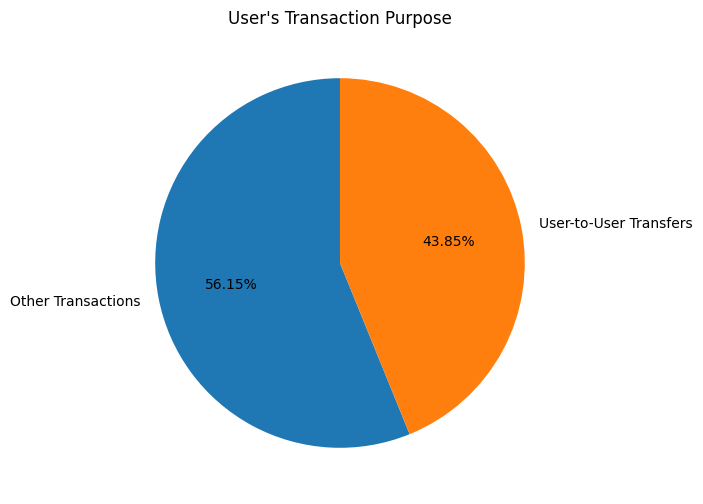

In [18]:
transactions_destination_percenrtage = df['transactions_purpose'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
transactions_destination_percenrtage.plot(kind="pie", autopct="%.2f%%", startangle=90)
plt.title("User's Transaction Purpose")
plt.ylabel("")
plt.show()

#### **6. What is Mediana Sum of User's Transfers?**

In [19]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')
median_value = df[df['transactions_purpose'] == 'User-to-User Transfers'].value.median() 

**For value in ETH divide median_value by 10^18**

In [20]:
median_value_ETH = round((median_value / 10**18), 4)
median_value_ETH

np.float64(0.0636)

#### **Medina Value is 0.636 ETH**

#### **7. What is Mean Sum of User's Transfers?**

In [21]:
mean_value_ETH = df[df['transactions_purpose'] == 'User-to-User Transfers'].value.mean()  / 10**18
mean_value_ETH

np.float64(9.822688454817714)

This is a huge difference between Mediana and Mean value. Probably, there are a lot of outliners.  
Look closer:

In [22]:
df[df['transactions_purpose'] == 'User-to-User Transfers'][['value']].describe()/ 10**18

,value
count,8.770000e-15
mean,9.822688e+00
std,4.918961e+02
min,0.000000e+00
25%,2.074420e-02
50%,6.364410e-02
75%,2.356489e-01
max,3.131060e+04


The dataset contains heterogeneous values. And  
***what is the reason in transfering 0 (zero) ETH?***

#### **7.1 How Many Zero Transactions in User-to-User Dectination?**

In [23]:
df[(df['transactions_purpose'] == 'User-to-User Transfers') & (df['value'] == 0.00)]

,from_address,first_transaction_time,to_address,value,input,gas,gas_price,transaction_type,receipt_gas_used,signature,function,transactions_purpose
181,0x99684cc2d7f6e7592ffe35a0906249bc334cb2fd,2023-05-21 09:31:47+00:00,0x2b82c78ae3c973c1ce39d63b5d63c6cb8db199ea,0.0,0x,31500,28793526918,2,21000,0x,Transfer,User-to-User Transfers
2642,0x80341e12ae82dbae74e955e7a85800b337820fab,2023-06-03 06:54:35+00:00,0xb6b039afc0ce83ddf613d6b742eba3b96943df0e,0.0,0x,30000,20095414391,2,21000,0x,Transfer,User-to-User Transfers
2680,0xa08ca3760a778076b7c2920e2ac74e838cb07f02,2023-09-05 18:24:23+00:00,0x34806cbba5698f9ca9f4aa4700348e56fe3ceb34,0.0,0x,27300,22722764197,2,21000,0x,Transfer,User-to-User Transfers
2867,0x2ef212074f43e62095222bafbfe5e691301a2a6c,2023-06-02 09:02:23+00:00,0x6265b90aaebd5e472760651639687c6cff8942e3,0.0,0x,21055,33600000000,0,21055,0x,Transfer,User-to-User Transfers
3288,0xcf7e209604aeb08d1f45b70cefde5f3b5194fdba,2023-06-02 10:29:35+00:00,0xb6b039afc0ce83ddf613d6b742eba3b96943df0e,0.0,0x,23000,24665763491,2,21000,0x,Transfer,User-to-User Transfers
...,...,...,...,...,...,...,...,...,...,...,...,...
16402,0x1e62bec1aca21e70288e195c4ffa9aeae88aeaca,2023-10-16 02:56:23+00:00,0x1e62bec1aca21e70288e195c4ffa9aeae88aeaca,0.0,0x,149293,6192828370,2,21000,0x,Transfer,User-to-User Transfers
17317,0xda2e1999319be0a159474d316710dfd1b4ac840e,2023-04-24 13:44:11+00:00,0xbbc7f7a6aadac103769c66cbc69ab720f7f9eae3,0.0,0x,80000,47834432462,2,21070,0x,Transfer,User-to-User Transfers
18712,0xd57e835b2fc5a3d03225e756b752890b1d18eef3,2023-06-06 04:01:47+00:00,0xec595717db71d29c5f3272c2b42d05d3cac1f5a4,0.0,0x,100000,22000000000,0,90578,0x,Transfer,User-to-User Transfers
18940,0x4572f7757d9a9d72f821e5980f501910ebcbe276,2023-06-06 12:45:11+00:00,0xec595717db71d29c5f3272c2b42d05d3cac1f5a4,0.0,0x,100000,32000000000,2,90578,0x,Transfer,User-to-User Transfers


#### **9. What is TOP-25 Contracts Exactly Are?**

In [40]:
top25_contracts = df[(df['function'] != 'Transfer') & (df['to_address'] != 'Contract')].to_address.value_counts().head(25).reset_index()

In [41]:
top25_contracts.head(3)

,to_address,count
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735


***Api does not have information about address's owners. It was collected address by address with Etherscan interface and ChatGPT help.***

In [42]:
contract_dict = {
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT (Tether) coin',
    '0x32400084c286cf3e17e7b677ea9583e60a000324': 'zkSync: Layer 2 Bridge',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC (USD Coin)',
    '0x881d4032abe4188e2237efcd27ab435e81fc6bb1': 'MetaMask Swap Router',
    '0xae0ee0a63a2ce6baeeffe56e7714fb4efe48d419': 'StarkGate ETH Bridge',
    '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad': 'Uniswap: Universal Router',
    '0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce': 'Shiba Inu (SHIB) token',
    '0xabea9132b05a70803a4e85094fd0e1800777fbef': 'zkSync: Layer 2 Bridge',
    '0x7a250d5630b4cf539739df2c5dacb4c659f2488d': 'Uniswap V2: Router 2',
    '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b': 'Uniswap: Universal Router 2',
    '0x06450dee7fd2fb8e39061434babcfc05599a6fb8': 'XEN Crypto (XEN) token',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0': 'Matic Token (MATIC) token',
    '0x881d40237659c251811cec9c364ef91dc08d300c': 'MetaMask: Swap Router',
    '0x514910771af9ca656af840dff83e8264ecf986ca': 'ChainLink Token (LINK)',
    '0xdef1c0ded9bec7f1a1670819833240f027b25eff': '0x Protocol: Exchange Proxy',
    '0x00000000219ab540356cbb839cbe05303d7705fa': 'Beacon Deposit Contract',
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'Wrapped Ether (WETH) token',
    '0xe66b31678d6c16e9ebf358268a790b763c133750': '0x: Coinbase Wallet Proxy',
    '0x1a0ad011913a150f69f6a19df447a0cfd9551054': 'Zora: Bridge',
    '0xd4307e0acd12cf46fd6cf93bc264f5d5d1598792': 'Base, Introduced token',
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'Dai Stablecoin (DAI)',
    '0x0000000000664ceffed39244a8312bd895470803': 'ENS: ETH Registrar Controller',
    '0x3506424f91fd33084466f402d5d97f05f8e3b4af': 'Chiliz (CHZ) token',
    '0xd19d4b5d358258f05d7b411e21a1460d11b0876f': 'Linea: L1 Message Service',
    '0x4d224452801aced8b2f0aebe155379bb5d594381': 'ApeCoin (APE) token'
}


In [43]:
top25_contracts['decoded_contracts'] = top25_contracts['to_address'].map(contract_dict)

In [44]:
top25_contracts

,to_address,count,decoded_contracts
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128,USDT (Tether) coin
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859,zkSync: Layer 2 Bridge
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735,USDC (USD Coin)
3,0x881d4032abe4188e2237efcd27ab435e81fc6bb1,570,MetaMask Swap Router
4,0xae0ee0a63a2ce6baeeffe56e7714fb4efe48d419,310,StarkGate ETH Bridge
5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,255,Uniswap: Universal Router
6,0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce,230,Shiba Inu (SHIB) token
7,0xabea9132b05a70803a4e85094fd0e1800777fbef,228,zkSync: Layer 2 Bridge
8,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,198,Uniswap V2: Router 2
9,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,167,Uniswap: Universal Router 2


In [45]:
def get_contract_functionality(decoded_contracts):
    if 'tether' in decoded_contracts.lower() or 'usd coin' in decoded_contracts.lower() or 'dai' in decoded_contracts.lower():
        return 'Stablecoin'
    elif 'uniswap' in decoded_contracts.lower() or 'metamask' in decoded_contracts.lower():
        return 'Router'
    elif 'bridge' in decoded_contracts.lower():
        return 'Bridge'
    elif 'token' in decoded_contracts.lower():
        return 'Token (NFT)'
    elif 'ens' in decoded_contracts.lower() or 'proxy' in decoded_contracts.lower() or 'beacon' in decoded_contracts.lower():
        return 'Infrastructure'
    else:
        return 'Other'

In [46]:
top25_contracts['contract_functionality'] = top25_contracts['decoded_contracts'].apply(get_contract_functionality)

In [47]:
top25_contracts

,to_address,count,decoded_contracts,contract_functionality
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128,USDT (Tether) coin,Stablecoin
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859,zkSync: Layer 2 Bridge,Bridge
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735,USDC (USD Coin),Stablecoin
3,0x881d4032abe4188e2237efcd27ab435e81fc6bb1,570,MetaMask Swap Router,Router
4,0xae0ee0a63a2ce6baeeffe56e7714fb4efe48d419,310,StarkGate ETH Bridge,Bridge
5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,255,Uniswap: Universal Router,Router
6,0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce,230,Shiba Inu (SHIB) token,Token (NFT)
7,0xabea9132b05a70803a4e85094fd0e1800777fbef,228,zkSync: Layer 2 Bridge,Bridge
8,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,198,Uniswap V2: Router 2,Router
9,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,167,Uniswap: Universal Router 2,Router


In [50]:
category_percentage = top25_contracts.groupby('contract_functionality')['count'].sum() / top25_contracts['count'].sum() * 100

plt.figure(figsize=(10, 6))
category_percentage.sort_values().plot(kind='barh', color='skyblue')

plt.title('TOP-25 Contracts by Functionality, %', fontsize=14)
plt.ylabel('  ', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


KeyError: 'category'

#### CONCLUSION